# Reformat the txt file for LASER handling

In [1]:
"""
# Good code, to do for all chapers
# Test: for chapter 1, there are 132 lines
from dataset import get_code_path
import numpy as np 
import re
for chapter in np.arange(1,10):

    with open(f"{get_code_path()}/experiments/formatting/text_lpp/new_test_run{chapter}.txt", 'r') as file:
        data = file.read()
    text = " ".join(data.split())
    # Split text into sentences with regex
    sentences = re.findall(r'[\w\s\S]+?[.?!]["\']?(?=\s|$)', text)
    with open(f"{get_code_path()}/data/txt_laser/run{chapter}.txt", "w") as file:
        for sentence in sentences:
            file.write(sentence + '\n')

"""

NameError: name 're' is not defined

# GFP for sentence - epoching on sentence end and go from there

In [1]:
# Homemade imports
from dataset import get_path, get_subjects, epoch_runs
from plot import plot_subject

# General imports
import numpy as np
import mne
import hydra
from omegaconf import DictConfig


In [2]:
path = get_path("LPP_read")
subjects = get_subjects(path)
RUN = 1
task = "read"
subject = subjects[4]
baseline_min = -4.0
baseline_max = 0.5
epoch_on = 'sentence'
reference = "end"

In [4]:
epochs = epoch_runs(subject, RUN, task, path, baseline_min,baseline_max, epoch_on=epoch_on ,reference=reference)

.
 Epoching for run 01, subject: 5

Opening raw data file /home/co/data/BIDS_lecture/sub-5/ses-01/meg/sub-5_ses-01_task-read_run-01_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 89000 ... 554999 =     89.000 ...   554.999 secs
Ready.
Reading events from /home/co/data/BIDS_lecture/sub-5/s

/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:99: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:99: RuntimeWarning: Omitted 128 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:99: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:99: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


1468 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Added embeddings
Adding metadata with 15 columns
134 matching events found


[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    4.0s finished


Setting baseline interval to [-4.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 134 events and 4501 original time points (prior to decimation) ...


/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:224: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=20 parameter will result in a sampling frequency of 50.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(


0 bad epochs dropped
Adding metadata with 16 columns
134 matching events found
Applying baseline correction (mode: mean)


/home/co/workspace_LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:312: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(epochs)


In [5]:
epochs.metadata

,level_0,index,Unnamed: 0,word,onset,duration,trial_type,start,condition,n_closing,is_last_word,pos,content_word,sentence_end,laser,label,kind
0,21,21,21,vécues,7.0,0.25,"{'kind': 'word', 'word': 'vécues'}",97.153,sentence,6,False,VPP,True,True,"[0.023229877, 0.024350138, -0.00015318407, 0.0...",run_1,word
1,30,30,30,fauve,10.2,0.25,"{'kind': 'word', 'word': 'fauve'}",100.020,sentence,5,False,NC,True,True,"[0.022218416, -0.00034505766, 0.0015076251, 0....",run_1,word
2,35,35,35,dessin,12.2,0.25,"{'kind': 'word', 'word': 'dessin'}",101.820,sentence,5,True,NC,True,True,"[-0.00026135266, 0.0016505849, -2.3930232e-05,...",run_1,word
3,50,51,51,mâcher,17.5,0.25,"{'kind': 'word', 'word': 'mâcher'}",106.586,sentence,4,False,VINF,True,True,"[0.017938925, -0.00026753946, -5.8330224e-05, ...",run_1,word
4,65,66,66,leur,22.5,0.25,"{'kind': 'word', 'word': 'leur'}",111.103,sentence,1,False,DET,False,True,"[0.013751491, -0.00038898917, -4.4464363e-05, ...",run_1,word
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,1376,1425,1425,aille,496.7,0.25,"{'kind': 'word', 'word': 'aille'}",537.843,sentence,5,True,VS,True,True,"[0.011370567, -6.920686e-05, 0.00038883876, 0....",run_1,word
130,1378,1427,1427,où,497.8,0.25,"{'kind': 'word', 'word': 'où'}",538.843,sentence,2,False,ADV,True,True,"[-0.000113535774, -0.00022956666, -0.000114733...",run_1,word
131,1380,1429,1429,devant,498.9,0.25,"{'kind': 'word', 'word': 'devant'}",539.826,sentence,1,False,P,False,True,"[0.0019510961, -0.0020051037, -0.00089106197, ...",run_1,word
132,1393,1444,1444,chez,503.9,0.25,"{'kind': 'word', 'word': 'chez'}",544.326,sentence,1,False,P,False,True,"[0.0077716443, 0.00020009138, -5.0174247e-05, ...",run_1,word


In [10]:
from utils import decod
R_vec = decod(epochs, decoding_criterion)

  0%|          | 0/226 [00:00<?, ?it/s]

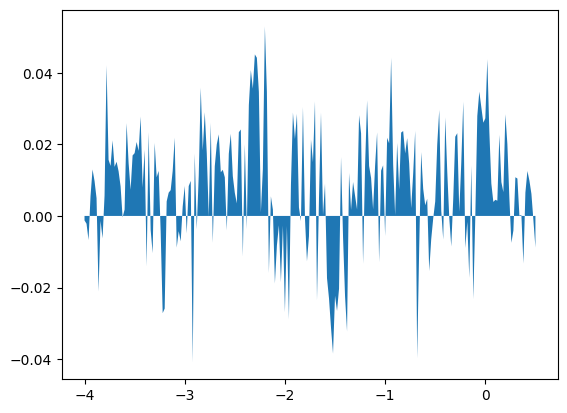

In [18]:
import matplotlib.pyplot as plt
plt.fill_between(epochs.times, R_vec)

In [ ]:
epochs.metadata

In [ ]:
np.diff(epochs.metadata.onset)

In [ ]:
epochs2 = epoch_runs(subject, RUN, task, path, baseline_min,baseline_max)

x 
x 
x 
x 
x 
x 
x 
x 
x 

In [ ]:
arr = np.round(np.diff(epochs2.metadata.onset),3)
unique, counts = np.unique(arr, return_counts=True)

# Print unique values and their counts
for val, count in zip(unique, counts):
    print(f"{val} occurs {count} times.")


In [ ]:
sum(np.diff(epochs2.metadata.onset)>0.7)

In [ ]:
evo = epochs.average(method="median")
evo.plot(gfp='only')

In [ ]:
epochs.events

In [ ]:
def epochs_(epochs, column, value):
    meta  = epochs.metadata
    subset = meta[meta[column]==value].level_0
    return epochs[subset]


In [ ]:
epochs.metadata['n_closing'][:50]

In [ ]:
epochs_(epochs,'is_last_word',True)

In [ ]:
import matplotlib.pyplot as plt
# Build a 3x2 plot, with for each condition (sentence, word, constituent), and for (start, end),
# the ERP associated
cond = {'sentence': {'column':'is_last_word','target':True},
        'word': {'column':'kind','target':'word'},
        'constituent': {'column':'n_closing','target':2}}

cases = {'start', 'end'}

i = 1
for condi in cond:
    for case in cases:
        ep = epochs_(epochs, cond[condi]['column'], cond[condi]['target'])
        ax = fig.add_subplot(3, 2, i)
        #ep.average().plot(gfp='only')
        evo = ep.average(method="median")
        evo.plot(spatial_colors=True)
        i = i + 1
        ax.set_title(f'Plot {cond}')


plt.show()


In [ ]:
epochs_4 = epochs_(epochs, 'n_closing', 4)

In [ ]:
epochs_4.average().plot(gfp='only')

In [ ]:
evo = epochs.average(method="median")
evo.plot(spatial_colors=True)

In [ ]:
metadata_subset

In [ ]:
from mne import Epochs

class CustomEpochs(Epochs):

    def __getitem__(self, key):
        # Parse the key into metadata field name and value
        field, value = key.split('==')
        field = field.strip()
        value = value.strip()

        # Get the indices of the epochs that match the metadata query
        indices = [i for i, metadata in enumerate(self.metadata[field]) if metadata == value]

        # Return a new Epochs object containing only the matching epochs
        return self.__class__(self._data[indices], self.events[indices], self.event_id,
                              tmin=self.tmin, tmax=self.tmax, baseline=self.baseline,
                              metadata=self.metadata.iloc[indices], info=self.info)



In [ ]:
custom_epochs = CustomEpochs(epochs, epochs.events, "1", -0.2, 0.8, epochs.baseline, epochs.metadata)

# Get all epochs where the 'kind' metadata field is 'word':
word_epochs = custom_epochs['kind==word']

In [ ]:
custom_epochs['kind=="word"']

In [ ]:
# epoch
def mne_events(meta):
    events = np.ones((len(meta), 3), dtype=int)
    events[:, 0] = meta.start*raw.info['sfreq']
    return dict(events=events, metadata=meta.reset_index())

epochs = mne.Epochs(raw, **mne_events(meta), decim=20, tmin=-.2, tmax=1.5, preload=True)
epochs = epochs['kind=="word"']

In [ ]:
from dataset import get_path, get_subjects, epoch_data, epoch_runs
from utils import (
    decod,
    correlate,
    match_list,
    create_target,
    analysis,
    save_decoding_results,
)
from plot import plot_subject
import mne_bids
from pathlib import Path
import pandas as pd
import numpy as np
import mne
import spacy
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import RidgeCV
from wordfreq import zipf_frequency
from Levenshtein import editops
import matplotlib.pyplot as plt

In [ ]:
path = get_path("LPP_read")
subjects = get_subjects(path)
RUN = 9
task = "read"
subject = subjects[4]

In [ ]:
epochs = epoch_runs(subject, RUN, task, path)

In [ ]:
(epochs.metadata).dtype

In [ ]:
epochs.load_data()
epochs = epochs['kind=="word"']
epochs["content_word == False"]